<p style="font-size:32px;text-align:center"> <b>Amazon.com - Employee Access Challenge</b> </p>

**Please refer my blog on Medium for a complete end to end explaination of the various experiments done in this notebook : https://pratik-sen-bmu.medium.com/amazon-com-employee-access-challenge-9a7235127fc8**

### Problem statement: 
Predict an employee's access needs, given his/her job role

### Problem Description:
When an employee at any company starts work, they first need to obtain the computer access necessary to fulfill their role. This access may allow an employee to read/manipulate resources through various applications or web portals. It is assumed that employees fulfilling the functions of a given role will access the same or similar resources. It is often the case that employees figure out the access they need as they encounter roadblocks during their daily work (e.g. not able to log into a reporting portal). A knowledgeable supervisor then takes time to manually grant the needed access in order to overcome access obstacles. As employees move throughout a company, this access discovery/recovery cycle wastes a nontrivial amount of time and money.

There is a considerable amount of data regarding an employee’s role within an organization and the resources to which they have access. Given the data related to current employees and their provisioned access, models can be built that automatically determine access privileges as employees enter and leave roles within a company. These auto-access models seek to minimize the human involvement required to grant or revoke employee access.

### Data Overview
Taken data from Amazon.com - Employee Access Challenge on kaggle https://www.kaggle.com/c/amazon-employee-access-challenge
The data consists of real historical data collected from 2010 & 2011.  Employees are manually allowed or denied access to resources over time. You must create an algorithm capable of learning from this historical data to predict approval/denial for an unseen set of employees. 
    - Data columns (total 10 columns):  


<table>
  <col width="130">
  <col width="10">
  <tr>
    <th>Column Name</th>
    <th>Description</th>
  </tr>
  <tr>
    <td>ACTION</td>
    <td>ACTION is 1 if the resource was approved, 0 if the resource was not</td>
  </tr>
  <tr>
    <td>RESOURCE</td>
    <td>An ID for each resource</td>
  </tr>
    <tr>
    <td>MGR_ID</td>
    <td>The EMPLOYEE ID of the manager of the current EMPLOYEE ID record; an employee may have only one manager at a time</td>
  </tr>
    <tr>
    <td>ROLE_ROLLUP_1</td>
    <td>Company role grouping category id 1 (e.g. US Engineering)</td>
  </tr>
    <tr>
    <td>ROLE_ROLLUP_2</td>
    <td>Company role grouping category id 2 (e.g. US Retail)</td>
  </tr>
    <tr>
    <td>ROLE_DEPTNAME</td>
    <td>Company role department description (e.g. Retail)</td>
  </tr>
    <tr>
    <td>ROLE_TITLE</td>
    <td>Company role business title description (e.g. Senior Engineering Retail Manager)</td>
  </tr>
    <tr>
    <td>ROLE_FAMILY_DESC</td>
    <td>Company role family extended description (e.g. Retail Manager, Software Engineering)</td>
  </tr>
    <tr>
    <td>ROLE_FAMILY</td>
    <td>Company role family description (e.g. Retail Manager)
</td>
  </tr>
    <tr>
    <td>ROLE_CODE</td>
    <td>Company role code; this code is unique to each role (e.g. Manager)
</td>
  </tr>
</table>


### Mapping the problem into supervised learning problem:
- Generated new features like Pair wise column featurization. Considered pairs of 2 columns as well as pairs of 3 columns, and analysed if these feature pairs help to improve the model prediction. 

### Business objectives and constraints:  
- The objective of this competition is to build a model, learned using historical data, that will determine an employee's access needs, such that manual access transactions (grants and revokes) are minimized as the employee's attributes change over time. The model will take an employee's role information and a resource code and will return whether or not access should be granted.
- Latency is not an issue here.

### Performance metric for supervised learning:  
- AUC (As mentioned in the competition evaluation criteria)

# 1 Reading the Train data

In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.feature_extraction.text import TfidfVectorizer #Equivalent to CountVectorizer followed by TfidfTransformer.

from sklearn.feature_extraction.text import CountVectorizer ##Convert a collection of text documents to a matrix of token counts
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string

import pickle
import os
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from math import log10
from sklearn.ensemble import RandomForestClassifier

In [ ]:
%matplotlib inline

In [ ]:
# Read the train data
result_train = pd.read_csv('/kaggle/input/amazon-employee-access-challenge/train.csv')
print('Number of data points : ', result_train.shape[0])
print('Number of features : ', result_train.shape[1])
print('Features : ', result_train.columns.values)

In [ ]:
# Get the total categories present in each column of the dataframe
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.nunique.html

result_train.nunique()

If we closely observe, “ROLE_TITLE” and “ROLE_CODE” have exactly the same number of categories. Hence there is a possibility that every unique ROLE_TITLE is mapped to an unique ROLE_CODE. 
Let’s investigate this a little further

Let’s drop the duplicate rows across ‘ROLE_TITLE’and ‘ROLE_CODE’ except the first occurrence of a particular category and get the number of Unique ‘ROLE_TITLE’ and ‘ROLE_CODE’.

IF the Unique values is still 343 for both ‘ROLE_TITLE’ and ‘ROLE_CODE’, then it means that there is a one to one mapping

In [ ]:
# Let's drop the duplicate rows accross 'ROLE_TITLE'and 'ROLE_CODE' except the first occurence and get the shape
# IF the Unique values is still 343 for both 'ROLE_TITLE' and 'ROLE_CODE'
# then it means that there is a one to one mapping

result_train.drop_duplicates(subset=['ROLE_TITLE', 'ROLE_CODE']).nunique()

Since there is a one-to-one mapping , we can drop either ‘ROLE_TITLE’ or ‘ROLE_CODE’.

Note: In the drop_duplicates code, inplace = False by default, this means that the original dataframe still remains unchanged

In [ ]:
#count NaN values in coumn in dataframe
result_train.isnull().sum()

There are no NaN values in the dataframe.

Now check for the Count of each class in the dataframe. This will tell us if the dataset is balanced or imbalanced.

In [ ]:
#count of each class in dataframe: https://stackoverflow.com/questions/36004976/count-frequency-of-values-in-pandas-dataframe-column
result_train.ACTION.value_counts()

This is a highly imbalanced data. Any dummy dumb model which always predicts class = 1 on the train data, will give an accuracy of 93 %. This means that only if the model that we would build, gives an accuracy more than 93%, then only we can say that the ML model has learned something

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
# sns.pairplot(result_train, hue="ACTION" , size=6)
# plt.show()
sns.pairplot(result_train, hue="ACTION")

From the pair-plots as well, it’s quite evident that the data is not separable with the current features.

From the above plots ,I did not find any pdf-plot or scatter plot which separates the 2 classes.
Note that the type of data here is Categorical, and not Numerical. Later, we will have to do One-Hot-Encoding using CountVectorizer. But the CountVectorizer expects the data to be text data. Therefore , we need to explicitly convert the columns into Type: Str

# 2.Preparing data for Models

**First Convert the Columns in Train to str**

In [ ]:
# We need to convert the columns to string as countVectorizer will not work with integer values
# https://www.geeksforgeeks.org/change-data-type-for-one-or-more-columns-in-pandas-dataframe/

convert_dict = {'RESOURCE': str, 
                'MGR_ID': str, 'ROLE_ROLLUP_1': str, 'ROLE_ROLLUP_2': str, 'ROLE_DEPTNAME': str, 'ROLE_TITLE': str,
                'ROLE_FAMILY_DESC': str,'ROLE_FAMILY': str,'ROLE_CODE': str
               } 

result_train = result_train.astype(convert_dict)  # Because countVectorizer will not work with integer values, hence we are converting the columns to str

result_train.head()

**Convert the Columns in Test to str**

In [ ]:
result_test = pd.read_csv('/kaggle/input/amazon-employee-access-challenge/test.csv')
print('Number of data points : ', result_test.shape[0])
print('Number of features : ', result_test.shape[1])
print('Features : ', result_test.columns.values)
convert_dict = {'RESOURCE': str, 
                'MGR_ID': str, 'ROLE_ROLLUP_1': str, 'ROLE_ROLLUP_2': str, 'ROLE_DEPTNAME': str, 'ROLE_TITLE': str,
                'ROLE_FAMILY_DESC': str,'ROLE_FAMILY': str,'ROLE_CODE': str
               } 

result_test = result_test.astype(convert_dict)  # Because countVectorizer will not work with integer values


In [ ]:
# drop the ACTION column from the train data
y_true = result_train['ACTION'].values
result_train = result_train.drop(['ACTION', 'ROLE_TITLE'], axis=1)
result_test = result_test.drop(['id','ROLE_TITLE'], axis=1)

**Apply TSNE to check if train data is separable based on ACTION**

Let’s see TSNE plot on the train data and check if TSNE can separate the data based on the original features of the dataset.
I have written a function for TSNE which I can call later to show the plot.

In [ ]:
# Code is taken from AAIC tutorial notebooks

# https://stackoverflow.com/questions/43757820/how-to-add-a-variable-to-python-plt-title/43758816

import numpy as np
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

def plot_TSNE(x,y,perplexity):
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=200)

    tsne_data = tsne.fit_transform(x)
    # if x is a sparse matrix you need to pass it as X_embedding = tsne.fit_transform(x.toarray()) , .toarray() will convert the sparse matrix into dense matrix

    tsne_data = np.vstack((tsne_data.T, y)).T
    tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

    # Ploting the result of tsne
    sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
    plt.title('TSNE with BOW encoding of project_title feature and PERPLEXITY=%s ' %perplexity)
    plt.show()


    

In [ ]:
x= result_train
y= y_true

plot_TSNE(x,y,30)

We can run TSNE on different perplexity values and check the plot if there is any separation and consistency. E.g- TSNE shows class separation at perplexity = 30 as well as 50, then we can say that TSNE’s output is consistent and trusted.

In [ ]:
plot_TSNE(x,y,50)

As we can see, in both the plots, there are multiple cluster being formed and the class labels are not getting separated. Therefore, TSNE on the original data could not separate the classes.

## 2.1 PairWise featurization(of degree 2) for Train data

We will create new features based on pair-wise combination of the original column. We will create pairs of degree 2 and degree 3 in both Train and Test data.
Therefore the total number of columns formed should be 8C2 + 8C3 + 8 = 92

So I have created 2 functions to create pairs of degree 2 and degree 3.

In [ ]:
# https://stackoverflow.com/questions/43347939/all-possible-combinations-of-columns-in-dataframe-pandas-python
# this helper function combines columns in pairs of 2. We will find out if this feature engineering technique creates a better ML model
# the result of pairing is columnX_columnY
def group_data_2(res):
  df = res
  cc = list(combinations(df.columns,2))
  df = pd.concat([df[c[0]] + '_' + df[c[1]] for c in cc], axis=1, keys=cc)
  df.columns = df.columns.map('_'.join)
  return df

In [ ]:
# this function combines columns in pair of 3
# the result of pairing is columnX_columnY_columnZ
def group_data_3(res):
  df = res
  cc = list(combinations(df.columns,3))
  df = pd.concat([df[c[0]] + '_' + df[c[1]] + '_' + df[c[2]] for c in cc], axis=1, keys=cc)
  df.columns = df.columns.map('_'.join)
  return df

In [ ]:
result_train.dtypes

In [ ]:
from itertools import combinations
result2 = group_data_2(result_train)
result3 = group_data_3(result_train)

frames = [result_train,result2,result3]
result_train = pd.concat(frames,axis=1)

# pickle_out = open("/kaggle/output/result_train.pickle","wb")
# pickle.dump(result_train, pickle_out)
# pickle_out.close()

In [ ]:
# lets see the new columns that are formed in the training data. 
# The total columns should be 8C2 + 8C3 + 8 = 92
print(result_train.columns)
print('-'*100)
print("Total number of columns in Train are: ",len(result_train.columns))

Also, we can go for more higher degrees if we wish. But this means more features and time complexity of the ML models will increase. So , we will only use degrees 2 and 3.

Lets plot TSNE for this new feature set

In [ ]:
x= result_train
y= y_true

plot_TSNE(x,y,10)

In [ ]:


plot_TSNE(x,y,30)

Now it looks like the data is taking some shapes and the label 0 (blue points) are at the periphery of the circular shape formed. We get the same shape in all the above 2 TSNE plots. So, the data is a little more interesting now.

Like we created Pair-Wise featurization for Train data, we will do the same for the Test data that we got from Kaggle


## 2.2 PairWise featurization(of degree 2) for Test data

In [ ]:
# feature engineering: combining columns in pairs of 2
# the result is columnX_columnY and then concatinating all the singular columns with the resultant pairwise combination.
result2 = group_data_2(result_test)
result3 = group_data_3(result_test)
# result4 = group_data_4(result_test)
frames = [result_test,result2,result3]
result_test = pd.concat(frames,axis=1)

In [ ]:
# lets see the new columns that are formed in the training data. 
# The total columns should be 8C2 + 8C3 + 8 = 92
print(result_test.columns)
print('-'*100)
print("Total number of columns in Test are: ",len(result_test.columns))

In [ ]:
result_test.head()

# 3.Frequency encoding

Count or Frequency Encoding implies replacing the categories of a categorical variable with the count or percentage of observation that the specific category has in the dataset. 
It shows how frequent / predominant that category is. Again, the advantages and disadvantages are same as that of Target Encoding. 
E.g.- Frequency of Red will be 2/5 = 0.4

In [ ]:
freq_frame = {}
combined_data = pd.concat([result_train, result_test], ignore_index = True)
new_dataset = pd.DataFrame()
for col in result_train.columns:
    data = combined_data.groupby([col]).size().reset_index()
    freq = combined_data[[col]].merge(data, on = col, how = "left")[0]
    new_dataset[col+"_freq"] = freq
    combined_data[col+"_freq"] = freq

    freq2 = (combined_data[[col,col+"_freq"]].groupby(col)[col+"_freq"].mean())
    freq_frame[col] = freq2

train_freq = new_dataset[:result_train.shape[0]]
test_freq =  new_dataset[result_train.shape[0]:]


pickle_out = open("freq_frame.pickle","wb")
pickle.dump(freq_frame, pickle_out)
pickle_out.close()

In [ ]:
print("Shape of train_freq dataframe: ", train_freq.shape)
print("Shape of test_freq dataframe: ",test_freq.shape)

In [ ]:
train_freq.head()

In [ ]:
test_freq = test_freq.reset_index(drop=True)


In [ ]:
test_freq.head()

# 4.Target Encoding

Mean or target encoding as a form of encoding in categorical variables. Mean encoding implies replacing the categorical values by the average target value for that specific category. An advantage of this type of feature engineering is that It does not expand the feature space. 

But there is 1 disadvantage of Target encoding: If 2 categories show the same mean of target, they will be replaced by the same number and this may lead to potential loss of information. This disadvantage also exists with frequency encoding as well. 

E.g.- Mean Encoding of Red will be (1+0)/2 = 0.5

In [ ]:
# Storing the column names in a list, we will use this later in SVD and countVectorization
list_col = list(result_train.columns)

## 4.1 Target encode Train

In [ ]:
columns_names = list_col # give the name of the list of columns that you want to do target encoding on
data_frame = {} # This will hold key-value pairs. Key will be the column name and value will be the target encoding for that column

In [ ]:
# https://necromuralist.github.io/kaggle-competitions/posts/mean-encoding-the-competition-data/ 
# https://necromuralist.github.io/kaggle-competitions/posts/mean-encoding/ 

X = result_train[columns_names].copy()
y = y_true
X['target'] = y
train_new = pd.DataFrame(index=X.index, columns=X.columns)
# This will hold key-value pairs. 
# Key will be the column name and value will be the target encoding for that column
data_frame = {} 

# QUES: Why are we doing StatifiedKFold split ?
# ANS: Generate test sets such that all contain the same distribution of classes, or as close as possible.
folds = StratifiedKFold(n_splits=5, random_state = 545167, shuffle = True)

for training_index, validation_index in folds.split(X,y):
    x_train = X.iloc[training_index].copy()
    x_validation = X.iloc[validation_index]
    # 'columns' is a list of columns to encode
    for column in columns_names:
        means = x_validation[column].map(x_train.groupby(column)['target'].mean())
        x_validation[column] = means
        means2 = (x_train[[column,"target"]].groupby(column)['target'].mean())
        data_frame[column] = means2.reset_index()

    # train_new is a dataframe copy we made of the training data
    train_new.iloc[validation_index] = x_validation

global_mean = X["target"].mean()

# replace nans with the global mean
train_new.fillna(global_mean, inplace=True)

# Save the dictionary "data_frame"
# import pickle

# pickle_out = open("data_frame.pickle","wb")
# pickle.dump(data_frame, pickle_out)
# pickle_out.close()

# pickle_out = open("global_mean.pickle","wb")
# pickle.dump(global_mean, pickle_out)
# pickle_out.close()

In [ ]:
train_new.drop(columns=['target'],inplace=True)
train_new.head()

In [ ]:
train_target = train_new.copy()

## 4.2 Target encode Test

In [ ]:
# https://pythonprogramming.net/python-pickle-module-save-objects-serialization/ 

# pickle_in = open("data_frame.pickle","rb")
# data_frame = pickle.load(pickle_in)
# pickle_in.close()

# pickle_in = open("global_mean.pickle","rb")
# global_mean = pickle.load(pickle_in)
# pickle_in.close()

test_X = result_test[columns_names].copy()
for c in test_X.columns:
  test_X[c] = (test_X[[c]].merge(data_frame[c], on = c, how = 'left'))["target"]
test_X = test_X.fillna(global_mean)
test_target = test_X.copy()

In [ ]:
test_target.head()


# 6.Adding SVD features + TfidfVectorizer to the train data

we did TF-IDF Vectorization on each of the 92 columns(got 92 columns after doing Pairwise featurization) and then initialized TruncatedSVD object(with “n_component = 1”) and fitted on each of these TfidfVectorizer objects . 

In [ ]:
## Declaring a dictionary for SVD features
cv= {} # Dictionary for CountVectorizer
svd = {} # Dictionary for SVD result, n_component = 1
result_train_svd_tfidf = pd.DataFrame()
result_test_svd_tfidf = pd.DataFrame()

In [ ]:
list_train = []
list_test = []
for name in list_col:
  val1 = 'X_train' + '_' + name 
  val2 = 'X_test' + '_' + name 
  list_train.append(val1)
  list_test.append(val2)

In [ ]:

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
vect_list = []
dim_red_list = []
X_train = result_train.copy()
X_test = result_test.copy()
for index,name in enumerate(list_train):
  name = name[8:]
  svd_name = name + '_svd'
  print("Calculating SVD datframe for For column : ",list_train[index][8: ])
  vectorizer = TfidfVectorizer()
  vectorizer.fit(X_train[name].values) # fit has to happen only on train data

  # Append the vectorizer to a list
  vect_list.append(vectorizer)

  # we use the fitted CountVectorizer to convert the text to vector
  cv[list_train[index]] = vectorizer.transform(X_train[name].values)
  # X_cv_ + str(s) = vectorizer.transform(X_cv[name].values)
  cv[list_test[index]] = vectorizer.transform(X_test[name].values)
  # Using Truncated SVD
  n_components=1
  dim_red = TruncatedSVD(n_components=n_components, random_state = 5511)
  dim_red.fit(cv[list_train[index]])
  
  dim_red_list.append(dim_red)

  svd[list_train[index]] = dim_red.fit_transform(cv[list_train[index]])
  svd[list_test[index]] = dim_red.transform(cv[list_test[index]])
  # Storing the SVD in the dataframe
  for i in range(n_components):
    k=str(i)
    result_train_svd_tfidf[svd_name+'_'+ k] = svd[list_train[index]][:,i]
    result_test_svd_tfidf[svd_name+'_'+ k] = svd[list_test[index]][:,i]

# pickle_out = open("vectorizer.pickle","wb")
# pickle.dump(vect_list, pickle_out)
# pickle_out.close()

# pickle_out = open("dim_red.pickle","wb")
# pickle.dump(dim_red_list, pickle_out)
# pickle_out.close()

In [ ]:
print(result_train_svd_tfidf.shape)
print(result_test_svd_tfidf.shape)

# 7.Concatinating the response coded features with the SVD features




Now , it’s time to concatenate the feature sets that we created .

Therefore, after concatenation, the result will have a dimensionality of 276 columns. This dimensionality is quite large to apply TSNE on. Therefore we will not be able to do TSNE here anymore.

In [ ]:
## Concatinating the dataframes
result_train_final = pd.concat([train_target , result_train_svd_tfidf, train_freq], axis=1)
result_test_final = pd.concat([test_target, result_test_svd_tfidf, test_freq], axis=1)

# result_train_final = pd.concat([train_freq], axis=1)
# result_test_final = pd.concat([test_freq], axis=1)

In [ ]:
print(result_train_final.shape)
print(result_test_final.shape)

In [ ]:
X_tr = result_train_final.values
X_te = result_test_final.values

# 8.Standard Scaling

In [ ]:
# when using classical ML models like Logistic Regression , SVM etc, its important to to standard scaling
# However Standard scaling is not needed when using tree based algo like Random forest

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_tr=scaler.fit_transform(X_tr)
X_te=scaler.fit_transform(X_te)

# 9.Machine Learning Models

## 9.2 Logistic regression with class weight = balanced

#### Hyper-Parameter tuning

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

folds = 5
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

classifier = SGDClassifier(class_weight='balanced', penalty='l2',loss='log', random_state=42)

parameters = {'alpha': [10 ** x for x in range(-6, -1)]}
clf = GridSearchCV(classifier, parameters, cv=skf, scoring='roc_auc', return_train_score=True)

clf.fit(X_tr, y_true)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In the above code, I am doing Hyperparameter tuning using GridSearchCV (with cross-validation splitting strategy as stratified k-fold cross-validation). StratifiedKFold() ensures that classes are equally distributed among each folds- In our case number of folds = 5.

Note that I have used SKLearn’s SGDClassifier with loss=‘log’. This will behave same as Logistic Regression. Also, I have used class_weight=‘balanced’ which will help slightly in the case of imbalanced dataset. This is a way to give more weightage to the minority class samples.

In [ ]:
clf.best_estimator_

In [ ]:
# from the above graph we can see that C=1 is the best hyper-parameter. we will use this value to build the best LR model.

from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

model = SGDClassifier(class_weight='balanced', alpha=0.001, penalty='l2', loss='log', random_state=42)
# cross_validate returns scores which is a dict of float arrays of shape (n_splits,)
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html

score = cross_validate(model, X_tr, y_true, groups=None, scoring='roc_auc', 
                       cv=skf, n_jobs=2, return_train_score = True)
score = pd.DataFrame(score) # we will store the score in a dataframe and then transpose this to find the mean test_score and mean train_score.

score.describe().transpose()

We have got a pretty good mean cross validation score of 0.883

## 9.3 Logistic regression without class balancing

#### Hyper-Parameter tuning

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

folds = 5
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

classifier = SGDClassifier( penalty='l2',loss='log', random_state=42)

parameters = {'alpha': [10 ** x for x in range(-6, -1)]}
clf = GridSearchCV(classifier, parameters, cv=skf, scoring='roc_auc', return_train_score=True)

clf.fit(X_tr, y_true)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [ ]:
clf.best_estimator_

In [ ]:
# from the above graph we can see that C=1 is the best hyper-parameter. we will use this value to build the best LR model.

from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
folds = 5
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

model = SGDClassifier(alpha=0.01, penalty='l2', loss='log', random_state=42)
# cross_validate returns scores which is a dict of float arrays of shape (n_splits,)
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html

score = cross_validate(model, X_tr, y_true, groups=None, scoring='roc_auc', 
                       cv=skf, n_jobs=2, return_train_score = True)
score = pd.DataFrame(score) # we will store the score in a dataframe and then transpose this to find the mean test_score and mean train_score.

score.describe().transpose()

Logistic Regression with class balancing gave better results than the Logistic Regression without Class balancing model

## 9.4 Linear Support Vector Machines

#### Hyper-Parameter tuning

In [ ]:


# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

folds = 5
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

classifier = SGDClassifier(class_weight='balanced',penalty='l2',loss='hinge', random_state=42)

parameters = {'alpha': [10 ** x for x in range(-6, 0)]}
clf = GridSearchCV(classifier, parameters, cv=skf, scoring='roc_auc', return_train_score=True)

clf.fit(X_tr, y_true)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [ ]:
clf.best_estimator_

In [ ]:

model = SGDClassifier(class_weight='balanced',alpha=0.1, penalty='l2', loss='hinge', random_state=42)
# cross_validate returns scores which is a dict of float arrays of shape (n_splits,)
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html

score = cross_validate(model, X_tr, y_true, groups=None, scoring='roc_auc', 
                       cv=skf, n_jobs=2, return_train_score = True)
score = pd.DataFrame(score) # we will store the score in a dataframe and then transpose this to find the mean test_score and mean train_score.

score.describe().transpose()

__Summary__
1. test_score of 0.888 is better than that of Logistic Regression model

## 9.5 Random Forest

#### Hyper-Parameter tuning

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
# How to take the log of all elements of a list: https://stackoverflow.com/questions/11656767/how-to-take-the-log-of-all-elements-of-a-list

folds = 5
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
clf = RandomForestClassifier(random_state=0)
parameters = {'n_estimators': [1200], 'max_depth': [10], 'min_samples_split': [2, 5, 10], 'min_samples_leaf':[1, 2, 4]}
clf = GridSearchCV(clf, parameters, cv=skf, scoring='roc_auc', return_train_score=True)
clf.fit(X_tr, y_true)


In [ ]:
clf.best_estimator_

In [ ]:
from sklearn.model_selection import cross_validate
folds = 5
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
model = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
score = cross_validate(model, X_tr, y_true, groups=None, scoring='roc_auc', 
                       cv=skf, n_jobs=2, return_train_score = True)
score = pd.DataFrame(score) # we will store the score in a dataframe and then transpose this to find the mean test_score and mean train_score.

score.describe().transpose()

Mean Test score improved lot ! It's 0.90

## 9.6 XGBoost

#### Using Randomized search cv

In [ ]:
# https://gist.github.com/wrwr/3f6b66bf4ee01bf48be965f60d14454d 
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

param_test ={
              'max_depth': [15, 20, 25, 30],
             'learning_rate': [0.1, 0.01, 0.001],
             'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5],
              'n_estimators':  [80, 90, 100, 120, 140],
            }


#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
clf = xgb.XGBClassifier()
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    scoring='roc_auc',
    cv=3,
    refit=True,
    return_train_score = True,
    random_state=314,
    verbose=True)

gs.fit(X_tr, y_true)

In [ ]:
print(gs.best_params_)

#### Building the model with best hyperparameters

In [ ]:
# fiiting the XGBoost with the best params
params = {'colsample_bytree': 0.4, 'learning_rate': 0.01, 'max_depth': 20, 'n_estimators': 100, 'subsample': 1} 

model = xgb.XGBClassifier(
        objective= 'binary:logistic', 
        random_state = 101,
        **params
    )
model.fit(X_tr, y_true)



#### Get the scores using cross_validate

In [ ]:
score = cross_validate(model, X_tr, y_true, groups=None, scoring='roc_auc', 
                       cv=skf, n_jobs=2, return_train_score = True)
score = pd.DataFrame(score) # we will store the score in a dataframe and then transpose this to find the mean test_score and mean train_score.

score.describe().transpose()

As we can see, XGBoost gave the best Mean Test score of 0.9058

Hence we will use this model to predict the Kaggle test data and make the kaggle submission

In [ ]:
# Save the trained XGBoost model so as to use it in future on any given test data.
Pkl_Filename = "model_new_xgb.pkl"  
with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(model, file)

# Load the Model back from file
with open(Pkl_Filename, 'rb') as file:  
    model = pickle.load(file)
    
# Do predictions on the test data
predictions = model.predict_proba(X_te)[:,1]

# Make the result ready for Kaggle submission
test = pd.read_csv('test.csv')
kaggle = pd.DataFrame()
kaggle["Id"] = test["id"]
kaggle["ACTION"] = predictions

kaggle.to_csv("svd-3/2-3-pairs-XGBoost.csv", index = False)

# 10.Summarization using pretty tables

In [ ]:
# http://zetcode.com/python/prettytable/

from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model", "Best HyperPrameter", "Mean Test Score", "Mean Train Score"]



x.add_row([" Logistic Regression", "C=0.01", 0.883655, 0.893479])
x.add_row([" Logistic regression with class balancing", "alpha=0.001", 0.883443, 0.886459])
x.add_row([" Logistic regression without class balancing", "alpha=0.001", 0.870494, 0.874968])


#x.add_row([" Linear Support Vector Machines", "alpha=0.001", 0.888272, 0.895446])

x.add_row([" Random Forest", "Max_depth=10, n_estimators=1200", 0.905047, 0.959425])

x.add_row([" ", " ", " " ,   " " ])
x.add_row([" XGBoost", " 'n_estimators': 100,", 0.905478 , 0.971856])
x.add_row([" ", " 'learning_rate': 0.01,", " " ,   " "])
x.add_row([" ", " 'colsample_bytree': 0.4,", " " ,   " "])
x.add_row([" ", " 'max_depth': 20", " " ,   " " ])


print(x)

## 5. Conclusion


<ol>
<li>
<h3>Data-Preprocessing : </h3>
It's found that role_code and Role_title has same number of categories. Each role_code is mapped to unique value of role_title. Hence we can drop role_code and keep role_title.
After this we can perform Pair-wise column featurinzation. Here columns we combined in pairs of 2 and pairs of 3.
Total number of features after doing pair-wise featurization is 92. We can perform TruncatedSVD dimentionality reduction on top of one-hot encoding.
i.e- One-hot encoding was done on each column and SVD with n_components = 1 was done.
Therefor the total SVD features are 92. Hence total number of columns after the end of data-preprocessing is 92+92 = 184  
</li>

<li>
<h3>LOGISTIC REGRESSION</h3>
we can work with One-hot-encoded data in Logistic Regression. Logistic Regression can work well with high dimentionality data  as its easier to find planes in high dimentional data and its easier to separate classes.
First we try with class balancing. Since we are doing class balancing(we are doing oversampling). Class balancing also help the minor class get a better precision and recall.

<li>
<h3>LINEAR SVM</h3>
one of the big advantages of linear svm is that they are very interpretable and works very well for high dimentional data.We are also doing class balancing. Here we are not using RBF_kernel because we dont know which kernel will work well for this kind of data.RBF kernel is
also not very interpretable.
</li>

<li>
<h3>Random Forest</h3>
Decision tree donot work well with high dimentionala data, so we tried to implement a better version of Decision tree, called Random forest.
In Random Forest, if the number of estimators increase than the model will generalize better.
</li>

<li>
<h3>XGBoost</h3>
XGBoost is an implementation of gradient boosted decision trees designed for speed and performance. Source: machinelearningmastery.com
</li>

</ol>

<h3>XGBoost model with 'colsample_bytree': 0.4,'eta': 0.01,'max_depth': 20, 'subsample': 1 gives the best AUC score</h3>
<h3>Kaggle Rank: 94</h3>

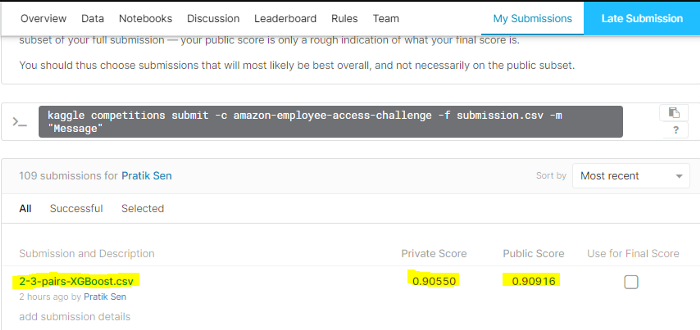